In [1]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image # PIL is a library to process images
from matplotlib import pyplot as plt
import VAE
from utils.data_helper import CustomDataset


# Visualize Some Examples

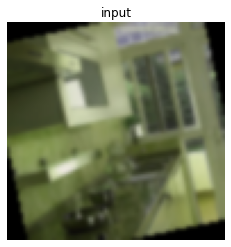

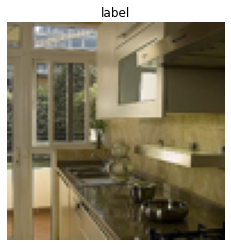

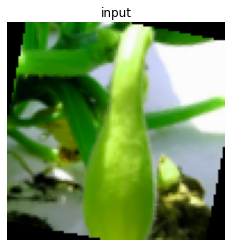

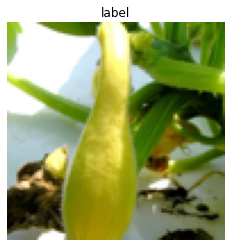

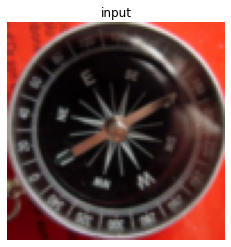

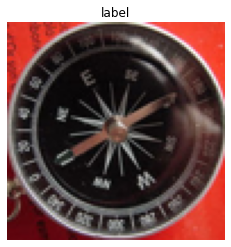

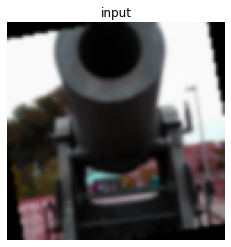

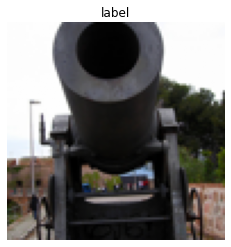

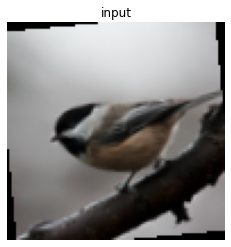

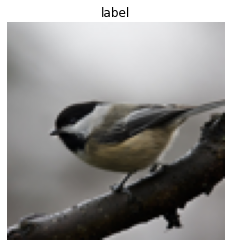

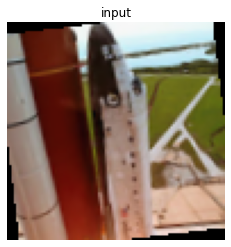

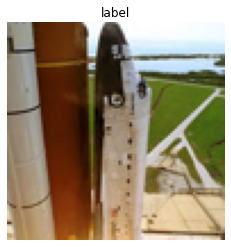

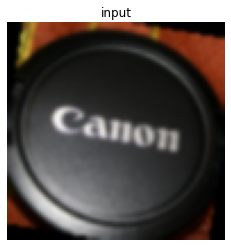

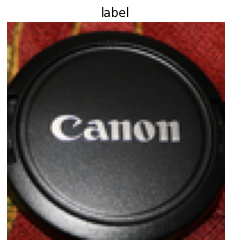

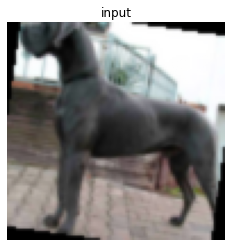

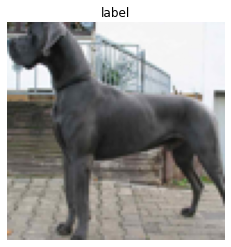

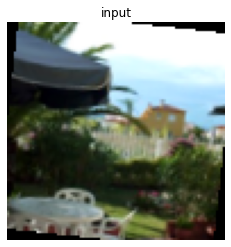

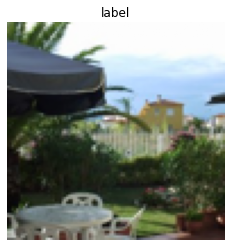

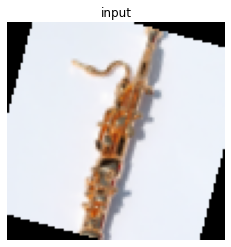

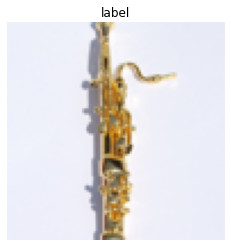

In [2]:
def show_normalized_image(img, title=None, normalize=False):
    if normalize:
        plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
    else: 
        plt.imshow(img.detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    
# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
        transforms.RandomRotation(20, resample=Image.BILINEAR),
        transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
        transforms.ToTensor(),  # convert PIL to Pytorch Tensor
        #normalize,
    ])


trainset = CustomDataset(root='./dataset', split="unlabeled", transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=4)
for epoch in range(1):
    running_loss = 0.0
    count =0;
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        count +=1
        plt.figure()
        show_normalized_image(inputs[0], 'input')
        #print(labels.shape)
        plt.figure()
        show_normalized_image(labels[0], 'label')
        if count ==10:
            break;


In [3]:
model = VAE.VAE(1600)

In [4]:
from tqdm.notebook import tqdm
import torch.optim as optim

epochs = 100
lr = 1e-3
save_path = './unlabeled.pth'
momentum=0.9

def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
    BCE = nn.functional.binary_cross_entropy(xhat.view(x.size(0), -1), x.view(x.size(0), -1), reduction='none').sum(1).mean()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

    loss = BCE + kl_weight*KLD
    return loss, BCE, KLD

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) 
model.train()
if torch.cuda.is_available():
    model = model.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

model.to(device)


train_mse_loss_record = []

for epoch in range(epochs):
    total_train_loss = 0.0
    for batch in tqdm(trainloader, leave=False):
        x_in = batch[0].to(device=device)
        x_label = batch[1].to(device=device)
        outputs, mu, logvar = model(x_in)
        loss, bce, kld = loss_function(outputs, x_label, mu, logvar, 0.5)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        print(loss.item())

    mean_train_loss = total_train_loss / len(trainset)

    train_mse_loss_record.append(mean_train_loss)
    
    if epoch%10 ==0 :
        torch.save(model.state_dict(), save_path)


  0%|          | 0/512000 [00:00<?, ?it/s]

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

In [ ]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.tight_layout()